# Digit Recognizer using CNN

## Import Libraries

In [95]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime

print('Pandas: ', pd.__version__)                       # 2.1.1
print('Numpy: ', np.__version__)                        # 1.24.3
print('Matplotlib: ', plt.matplotlib.__version__)       # 3.8.0
print('Tensorflow: ', tf.__version__)                   # 2.10.1
print('Keras: ', keras.__version__)                     # 2.10.0
print('Seaborn: ', sns.__version__)     	            # 0.12.2

Pandas:  2.1.1
Numpy:  1.24.3
Matplotlib:  3.8.0
Tensorflow:  2.10.1
Keras:  2.10.0
Seaborn:  0.12.2


### Check if tensorflow is using GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import Data

### Import CSV

Dataset was downloaded from Kaggle \
https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv


In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Define input (pixels) and output (labels) from dataset

Train dataset includes 785 columns, 1st column is label, rest is pixel values\
784px = 28x28 px images

In [4]:
print('train:', df_train.shape)
print('test:', df_test.shape)

# Select columns with pixel data
X = df_train.iloc[:, 1:785]         

# Select column with labels
y = df_train.iloc[:, 0]    

# Test dataset does not have labels
X_test = df_test.iloc[:, 0:784]     

train: (42000, 785)
test: (28000, 784)


## Visualize Data

### TSNE

#### Fit t-SNE algorithm

T-Distributed Stochiastic Neighbor Embedding could be useful to reduce the dimensions of the images for easier visualization.\
Currently the dataset has 784 dimensions (1 dimension for each pixel), where t-SNE brings that down to two dimensions.

In [5]:
from sklearn.manifold import TSNE

X_tsn = X/255       # normalize values - each pixel has a value between 0 - 255, so now each pixel has a value between 0 and 1

tsne = TSNE()
tsne_res = tsne.fit_transform(X_tsn)

#### Plot t-SNE

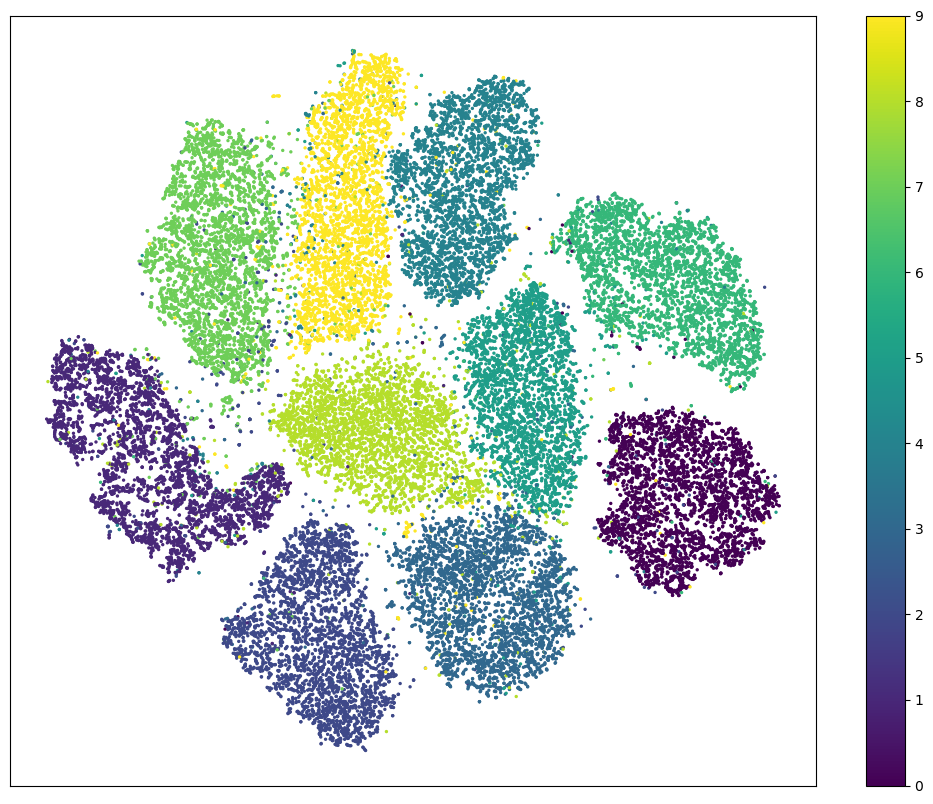

In [6]:
plt.figure(figsize=(13, 10))
plt.scatter(tsne_res[:, 0], tsne_res[:, 1], c=y, s=2)
plt.xticks([])
plt.yticks([])
plt.colorbar()

 - Each colour represents a digit from the dataset (0 to 9)
 - Digits are separated into clusters
 - The denser the group, the more data points are there that represent it
 - Outliers are points which are far away from the respective cluster

## Prepare Data

### Split into train and validate data

Since dataset is very big, I will only use half of it for training and 30% for validation (testing)\
Otherwise it would take more time to train a model

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.5, test_size=0.2, random_state=42)

### Check dimensions of train and validate sets 

In [8]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('df_test: ', df_test.shape)

X_train:  (21000, 784)
y_train:  (21000,)
X_val:  (8400, 784)
y_val:  (8400,)
df_test:  (28000, 784)


### Check if there are representations of all digits in the train dataset

In [9]:
print('Number of unique values: ', len(y_train.unique()))
print('Unique values: ', np.sort(y_train.unique()))

Number of unique values:  10
Unique values:  [0 1 2 3 4 5 6 7 8 9]


### Convert train, test and val data into numpy arrays

#### Reshape X_train array from two to three dimensions

In [10]:
x_train_re = X_train.to_numpy().reshape(21000, 28, 28)  # number of rows, x dimension, y dimension
y_train_re = y_train.values
x_val_re = X_val.to_numpy().reshape(8400, 28, 28)
y_val_re = y_val.values
x_test_re = df_test.to_numpy().reshape(28000, 28, 28)

#### Check dimensions of train and validate sets after reshaping

In [11]:
print('x_train: ', x_train_re.shape)
print('y_train: ', y_train_re.shape)
print('x_val: ', x_val_re.shape)
print('y_val: ', y_val_re.shape)
print('x_test: ', x_test_re.shape)

x_train:  (21000, 28, 28)
y_train:  (21000,)
x_val:  (8400, 28, 28)
y_val:  (8400,)
x_test:  (28000, 28, 28)


#### Save image parameters as constants for reshaping and training model

In [12]:
(_, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train_re.shape
IMAGE_CHANNELS = 1  # grayscale images have only one channel

print('IMAGE_WIDTH: ', IMAGE_WIDTH)
print('IMAGE_HEIGHT: ', IMAGE_HEIGHT)
print('IMAGE_CHANNELS: ', IMAGE_CHANNELS)

IMAGE_WIDTH:  28
IMAGE_HEIGHT:  28
IMAGE_CHANNELS:  1


### Reshaping arrays so each image can have multiple channels

Currently our dataset consists of grayscale images, that only have one channel. However in order to use convolution layers, we need to support all three (RGB) channels.\
\
Convolutional layers in TensorFlow expect data in the form of (batch_size, height, width, channels), and currently we have the numpy arrays with only the first three parameters.\
[Dimensions after reshaping with height and width](####-Check-dimensions-of-train-and-validate-sets-after-reshaping)

In [13]:
x_train_ch = x_train_re.reshape(
    x_train_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)
x_val_ch = x_val_re.reshape(
    x_val_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)
x_test_ch = x_test_re.reshape(
    x_test_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)
print('x_train with channels:', x_train_ch.shape)
print('x_val with channels:', x_val_ch.shape)
print('x_test with channels:', x_test_ch.shape)

x_train with channels: (21000, 28, 28, 1)
x_val with channels: (8400, 28, 28, 1)
x_test with channels: (28000, 28, 28, 1)


### Normalize data values

To normalize the data for training, the pixel values will be converted to the range of [0, 1]

In [14]:
x_train_norm = x_train_ch / 255
x_val_norm = x_val_ch / 255
x_test_norm = x_test_ch / 255

## Explore data

### Convert one image to a dataframe

In [15]:
pd.set_option('display.max_columns', None)
pd.DataFrame(x_train_re[0])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,63,253,121,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,63,254,202,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,163,255,144,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,167,251,26,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,9,212,153,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,89,237,104,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,5,214,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,74,254,124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We can see the digit 6 when showing the first row from the train set as a dataframe.

### Visualize digits with Matplotlib

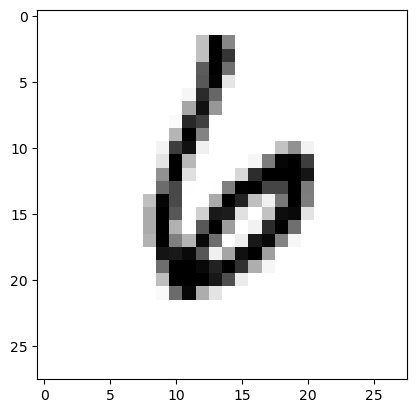

In [16]:
plt.imshow(x_train_re[0], cmap=plt.cm.binary)
plt.show()

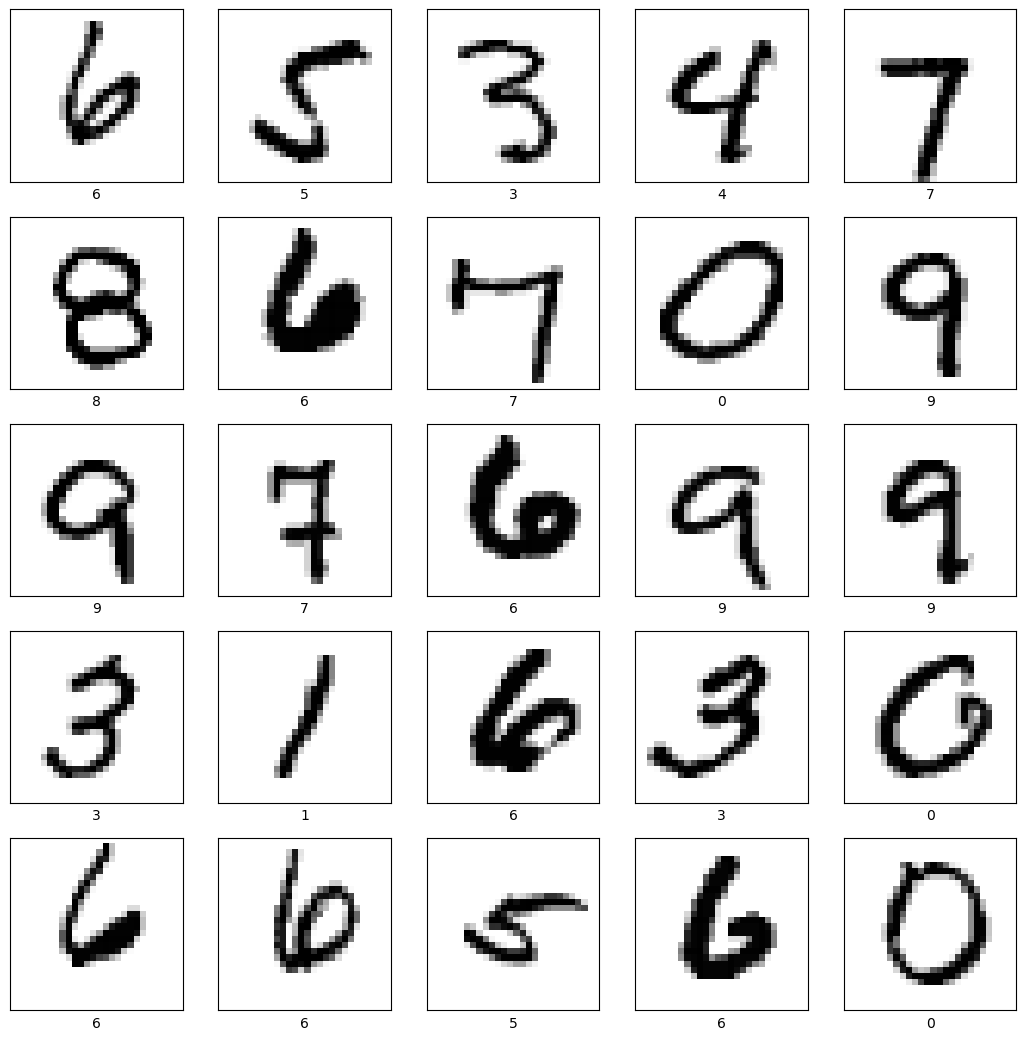

In [17]:
num_digits_to_display = 25
num_cells = math.ceil(math.sqrt(num_digits_to_display))

plt.figure(figsize=(13, 13))

for i in range(num_digits_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train_re[i], cmap=plt.cm.binary)
    plt.xlabel(y_train_re[i])
plt.show()

## Train Model

### Build CNN Model

#### Initialize sequential model

A sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

In [48]:
model = tf.keras.models.Sequential()

#### Add 2D convolutional layer to model

 - Layer will learn 8 filters (features) of size 5x5.
 - The input shape specifies the dimensions of the input (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
 - Strides is the number of steps the filter takes during the convolution operation
 - Using the ReLU (Rectified Linear Unit) function for activation after the convolution
 - VarianceScaline initializes weights in a way that maintains the variance of weights

In [49]:
model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

#### Add max-pooling layer

Max-pooling layer is added after the convolutional layer. Max-pooling is a down-sampling operation that reduces the spatial dimensions of the output volume. A 2x2 pooling window is used with a stride (step) of 2 in both dimensions.

In [50]:
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

#### Add second convolutional layer

Another convolutional layer is added with 16 filters of size 5x5. The input to this layer is the output from the previous max-pooling layer.

In [51]:
model.add(tf.keras.layers.Convolution2D(
    kernel_size=5,
    filters=16,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

#### Add second max-pooling layer

Another max-pooling layer is added after the second convolutional layer to further reduce spatial dimensions.

In [52]:
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

#### Add Flatten layer

The flatten layer transforms the input into a one-dimensional array. This is necessary before passinf the data to a fully dense layer.

In [53]:
model.add(tf.keras.layers.Flatten())

#### Add fully connected (dense) layer

Fully connected layer with 128 units and ReLU activation. This layer is designed to capture high-level features from the spatial information learned by the convolutional layers.

In [54]:
model.add(tf.keras.layers.Dense(
    units=128,
    activation=tf.keras.activations.relu
))

#### Add dropout layer

Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.

In [55]:
model.add(tf.keras.layers.Dropout(0.2))

#### Add final dense layer 

The final dense layer produces teh output of the network. The number of units is the number of classes we are aiming to recognize (10 digits), and the activation function is softmax, which is often used for multi-class classification problems. Similarly to the convolution layers the kernel initializer is set to VarianceScaling.

In [56]:
model.add(tf.keras.layers.Dense(
    units=10,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

#### Visualize model

##### Show model summary

In [57]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          3216      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

##### Show model diagram

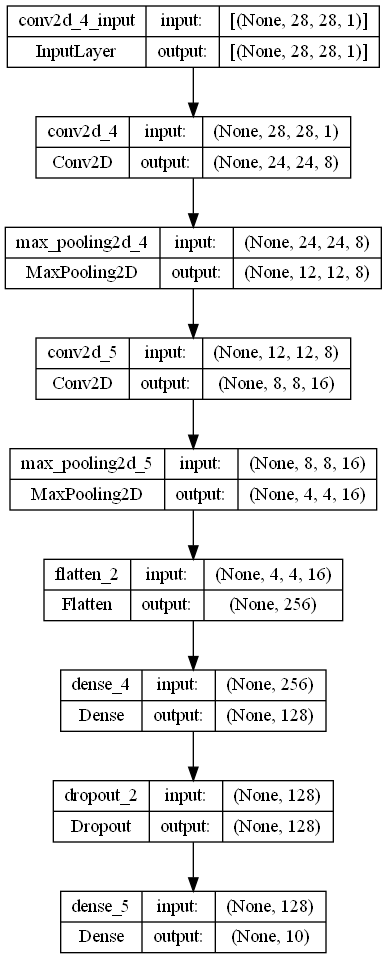

In [58]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

### Compile Model

Adam (Adaptive Moment Estimation) is an optimization algorithm commonly used for training neural networks, includng CNNs. The primary purpose of the Adam optimizer is to adjust the weights of the network in order to minimize the error or loss function during the training process.\
\
How does Adam work in the context of CNN:
 1. **Initializes** two moving average variables (*m* and *v*), which are estimates of the first moment and the second momennt of the gradients (gradient - partial derivatives of the loss function with respect to the model parameters, These partial derivatives indicate how much the loss would change with respect to a small change in each parameter).
 
 2. **Gradient Calculation** - during each iteration of training, the gradients of the model parameters with respect to the loss are calculated using backpropagation (backpropagation - supervised learning algorithm used to train artificial neural networks, whose main objective is to minimize the error or loss function by adjusting the model's parameters).
 
 3. **Bias Correction** - Adam applies bias correction to the moving averages to account for their initialization at zero. This helps in the early iterations of training when the estimates may be biased.
 
 4. **Parameter Update** - The parameters (weights and biases) of the model are updated using a combination of the current gradient and the exponentialy decaying average of past gradients. The update rule is a combination of the gradient infoormation (m) and the second moment (v).
 
 5. **Hyperparameters** - Adam has hyperparameters, such as the learning rate (α), exponential decay rates for the moment estimates (β<sub>1</sub> for m and β<sub>2</sub> for v)


In [59]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)        # moderate learning rate. Tensorflow uses it by default

model.compile(
    optimizer=adam,
    loss=tf.keras.losses.sparse_categorical_crossentropy,   # used in multi-class classification where each input belongs to a single class
    metrics=['accuracy']
)

### Train Model

In [60]:
log_dir = '.logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

# visualizations
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    x_train_norm,
    y_train_re,
    epochs=20,
    validation_data=(x_val_norm, y_val_re),
    callbacks=[tensorboard_callback]
)

print("Model has finished training.")

Epoch 1/20
 51/657 [=>............................] - ETA: 3s - loss: 1.7034 - accuracy: 0.4773

657/657 [==============================] - 5s 7ms/step - loss: 0.3752 - accuracy: 0.8850 - val_loss: 0.1413 - val_accuracy: 0.9555
Epoch 2/20
657/657 [==============================] - 4s 7ms/step - loss: 0.1217 - accuracy: 0.9619 - val_loss: 0.0969 - val_accuracy: 0.9713
Epoch 3/20
657/657 [==============================] - 4s 7ms/step - loss: 0.0892 - accuracy: 0.9720 - val_loss: 0.0712 - val_accuracy: 0.9781
Epoch 4/20
657/657 [==============================] - 4s 6ms/step - loss: 0.0707 - accuracy: 0.9772 - val_loss: 0.0664 - val_accuracy: 0.9789
Epoch 5/20
657/657 [==============================] - 4s 6ms/step - loss: 0.0583 - accuracy: 0.9811 - val_loss: 0.0600 - val_accuracy: 0.9801
Epoch 6/20
657/657 [==============================] - 4s 6ms/step - loss: 0.0483 - accuracy: 0.9840 - val_loss: 0.0644 - val_accuracy: 0.9792
Epoch 7/20
657/657 [==============================] - 4s 7ms/step - loss: 0.0400 - accuracy: 0.9870 - val_loss: 0.0498 - val_accuracy: 0.9839
Epoch 8/20
657/65

## Evaluate Model

### Plot loss for training and validation

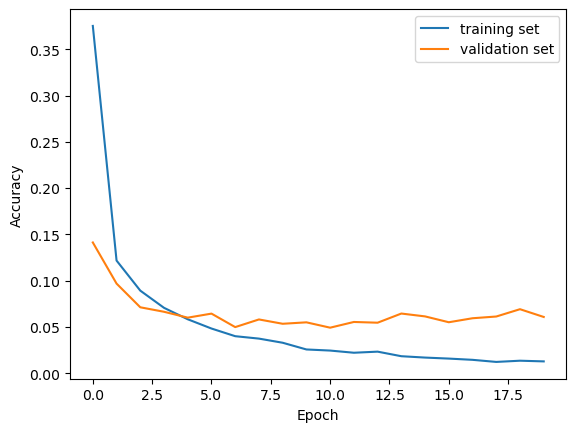

In [61]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(training_history.history['loss'], label='training set')
plt.plot(training_history.history['val_loss'], label='validation set')
plt.legend()

### Plot accuracy for training and validation

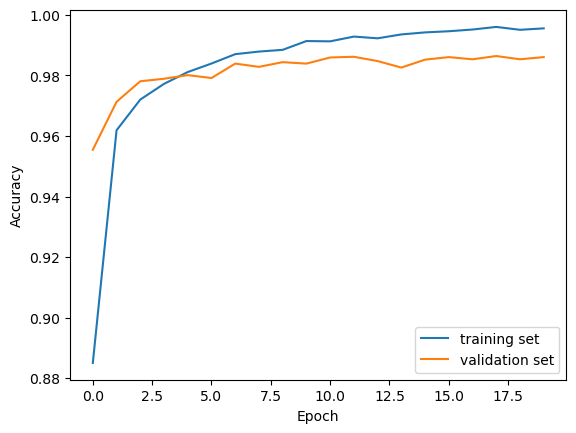

In [62]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(training_history.history['accuracy'], label='training set')
plt.plot(training_history.history['val_accuracy'], label='validation set')
plt.legend()

### Performance of training dataset

In [65]:
# %%capture
train_loss, train_accuracy = model.evaluate(x_train_norm, y_train_re)
print('Train loss: ', train_loss)
print('Train accuracy: ', train_accuracy)

657/657 [==============================] - 3s 5ms/step - loss: 0.0043 - accuracy: 0.9984
Train loss:  0.004277430009096861
Train accuracy:  0.9983809590339661


### Performance of validation dataset

In [67]:
# %%capture
val_loss, val_accuracy = model.evaluate(x_val_norm, y_val_re)
print('Validation loss: ', val_loss)
print('Validation accuracy: ', val_accuracy)

263/263 [==============================] - 1s 4ms/step - loss: 0.0608 - accuracy: 0.9861
Validation loss:  0.06078062579035759
Validation accuracy:  0.9860714077949524


## Export Model

In [69]:
model_name = 'digits_recognizer_cnn.h5'     # H5 extension for Keras models
model.save(model_name, save_format='h5')
loaded_model = tf.keras.models.load_model(model_name)

## Predict using trained model

### Visualize predicted data

263/263 [==============================] - 1s 2ms/step


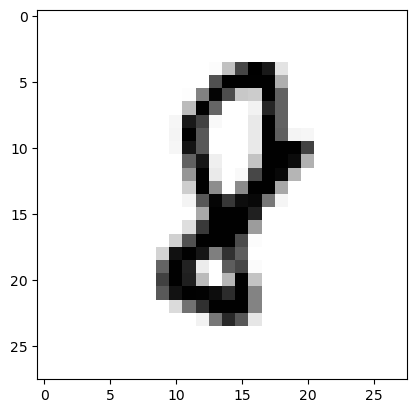

,0
0,8


In [79]:
predictions_one_hot = loaded_model.predict([x_val_norm])

# get predictions with highest probabilities and detect which digit has been recognized
predictions = np.argmax(predictions_one_hot, axis=1)
pred = pd.DataFrame(predictions)

# show first predicted image
plt.imshow(x_val_norm[0].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

#show first item from the predicted dataframe
pred.head(1)

We can see that the prediction is correct with the displayed image.

### Visualize more test examples

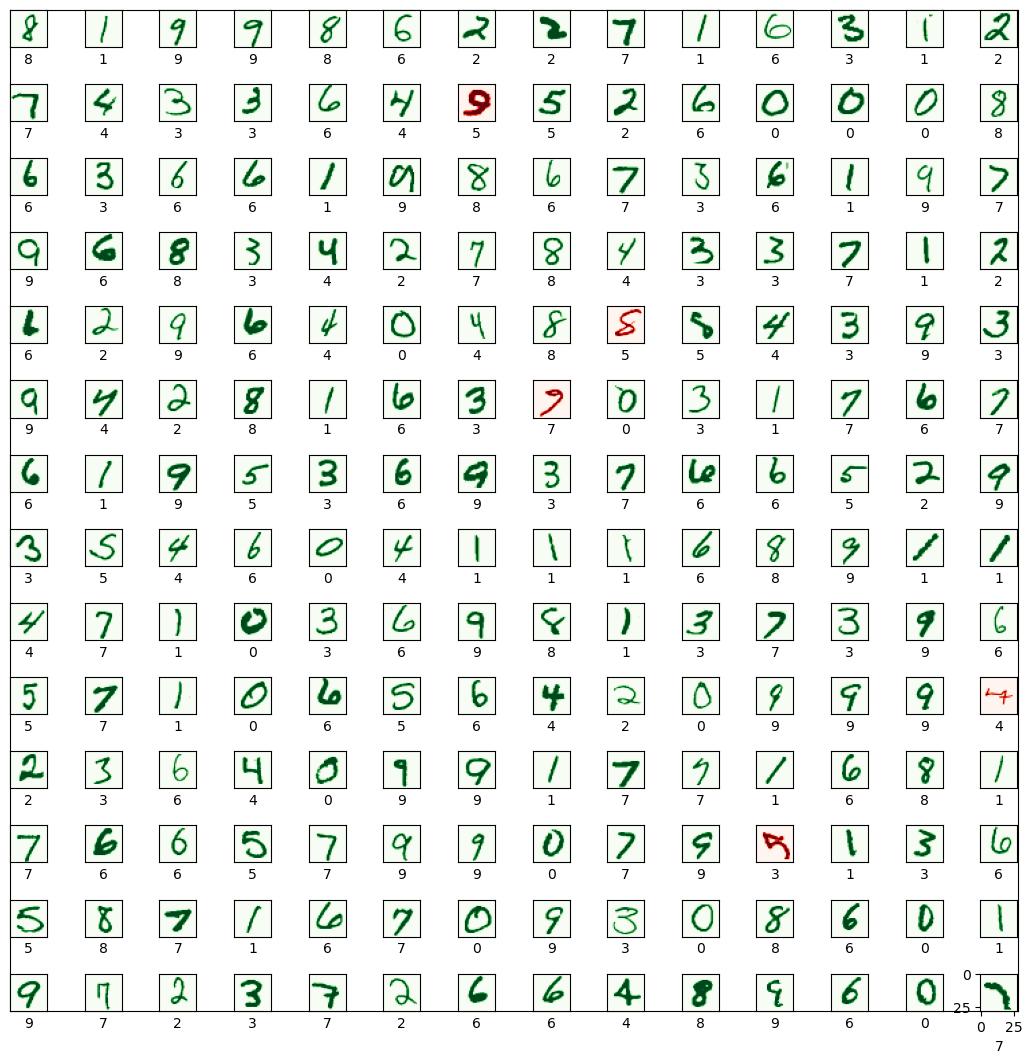

In [90]:
num_digits_to_display = 196

num_cells = math.ceil(math.sqrt(num_digits_to_display))

plt.figure(figsize=(13, 13))


for plot_index in range(num_digits_to_display):
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    colour_map = 'Greens' if predicted_label == y_val_re[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_val_norm[plot_index].reshape((IMAGE_WIDTH, IMAGE_WIDTH)), cmap=colour_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=1)
plt.show()